# VQGAN Analysis

## Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from dataset import AllCTsDataset
import dataset.utils as utils
from vq_gan_3d.model.vqgan import VQGAN

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load the model and dataset

In [3]:
checkpoint_path = "../checkpoints/vq_gan_3d/AllCTs/vqgan-05/best_val.ckpt"
model = VQGAN.load_from_checkpoint(checkpoint_path)
model.eval()

loaded pretrained LPIPS loss from c:\Users\giach\OneDrive\Documenti\Uni\Magistrale\Tesi\medicaldiffusion\vq_gan_3d\model\cache\vgg.pth


VQGAN(
  (encoder): Encoder(
    (conv_blocks): ModuleList(
      (0): Module(
        (down): SamePadConv3d(
          (conv): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (res): ResBlock(
          (norm1): GroupNorm(16, 32, eps=1e-06, affine=True)
          (conv1): SamePadConv3d(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (norm2): GroupNorm(16, 32, eps=1e-06, affine=True)
          (conv2): SamePadConv3d(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
        )
      )
      (1): Module(
        (down): SamePadConv3d(
          (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (res): ResBlock(
          (norm1): GroupNorm(16, 64, eps=1e-06, affine=True)
          (conv1): SamePadConv3d(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
    

In [4]:
dataset = AllCTsDataset(root_dir='../data/allcts-global-128', split='test', resize_d=1, resize_h=1, resize_w=1)

# Get reconstructed images

In [17]:
indices = np.random.choice(range(len(dataset)), (1,))
print(indices)
names = dataset.df.iloc[indices, 0].to_numpy()
names

[124]


array(['CT113'], dtype=object)

In [55]:
start = 5
indices = []
qualities = []
names = []
for i in range(10):
    quality = i+2
    if quality != 5:
        continue
    quality_df = dataset.input_df.loc[dataset.input_df.quality == i+2]

    name = quality_df.name.iloc[start]
    index_name = quality_df.index[start]
    index = dataset.df.index.get_loc(index_name)

    indices.append(index)
    qualities.append(quality)
    names.append(name)

indices, qualities, names

([19], [5], ['CTS095'])

In [56]:
reconstructed_images = []
for index in indices:
    img = dataset[index]
    batched_img = torch.unsqueeze(img['data'], 0)
    example_batch = {'data': batched_img}

    with torch.no_grad():
        reconstructed_image = model.test_step(example_batch, 0)
        reconstructed_images.append(reconstructed_image)


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2147483648 bytes.

## Visualize the images


In [8]:
all_images = []
all_names = []
for i, index in enumerate(indices):
    img = dataset[index]['data']
    name = names[i]
    quality = qualities[i]
    all_images.append(img)
    all_names.append(name + f'-original-q{quality}')
    all_images.append(reconstructed_images[i])
    all_names.append(name + f'-recon-q{quality}')

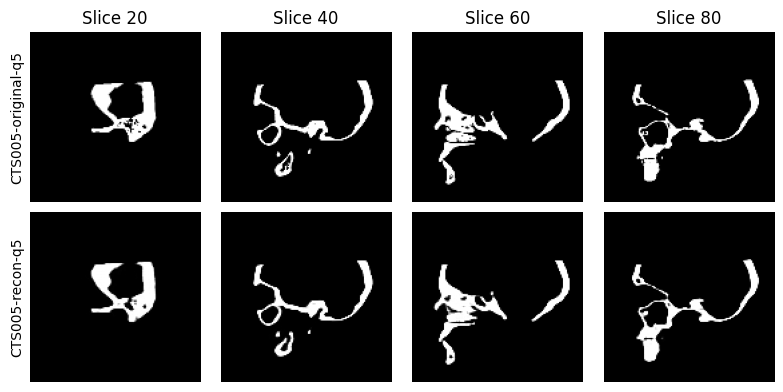

In [18]:
utils.show_image_grid(all_images, axis=1, names=all_names, slices=(range(20,100,20)))

## Build meshes from images

In [39]:
utils.build_mesh(torch.transpose(torch.squeeze(all_images[0]), 0, 1).detach().cpu().numpy(), threshold=0, name=all_names[0], output_folder='../data/mesh-test', spacing=[0.3345859, 0.46262616, 0.49944812])

TriangleMesh with 88074 points and 176260 triangles.


In [38]:
for i, img in enumerate(reconstructed_images):
    name = names[i] + f'-reconstructed'
    utils.build_mesh(torch.transpose(torch.squeeze(img), 0, 1).detach().cpu().numpy(), threshold=0, name=name, output_folder='../data/mesh-test', spacing=[0.3345859, 0.46262616, 0.49944812])

TriangleMesh with 84728 points and 169844 triangles.


In [25]:
for i, index in enumerate(indices):
    img = dataset[index]['data']
    name = names[i]
    img = torch.squeeze(img).detach().cpu().numpy()
    quality = np.argmax(dataset.df.iloc[index, 2:].to_numpy()) +2
    utils.build_mesh(img, threshold=0, name=name + f'-q{quality}', output_folder='../data/mesh-test')

TriangleMesh with 102768 points and 206240 triangles.
TriangleMesh with 33478 points and 67120 triangles.
TriangleMesh with 124046 points and 248328 triangles.
